In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import h2o

In [52]:
df = pd.read_excel("AML and ATF Modelling Assignment data_std.xlsx", sheet_name="data")
df.drop(columns=["cust_id_masked"], inplace=True)

X = df.drop(columns=["rating"]).to_numpy()
y = df["rating"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=2000)

In [53]:
rf = RandomForestClassifier(
    n_estimators=100, 
    criterion = "gini", 
    max_depth = None,
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_features = "sqrt",
    bootstrap = True,
    oob_score = False,
    random_state=2000,
    class_weight="balanced"
)
rf.fit(X_train, y_train)
print("training complete")

training complete


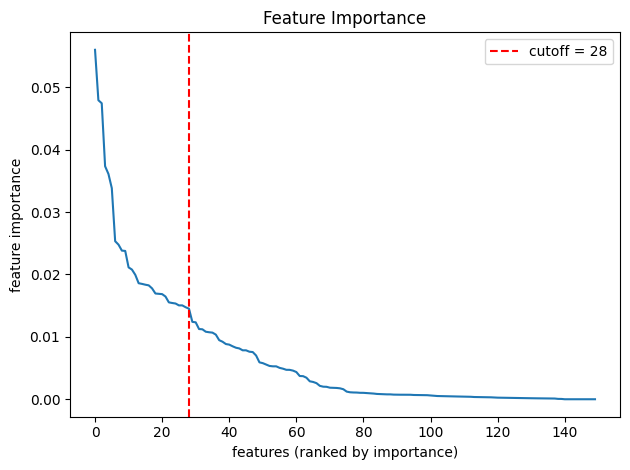

0: cust_tenure
1: cust_cdn_resident
2: prod_sav
3: prod_primary_sav_cnt
4: prod_cda
5: prod_primary_cda_cnt
6: prod_mor
7: prod_primary_mor_cnt
8: prod_llc
9: prod_primary_llc_cnt
10: prod_ted
11: prod_primary_ted_cnt
12: prod_crc
13: prod_primary_crc_cnt
14: prod_asset_balance
15: prod_liability_balance
16: prod_total_balance
17: prod_total_acct_cnt
18: prod_prim_acct_cnt
19: tot_acct_num
20: prod_none_prim_acct_cnt
21: geo_mail_addr_country_rate_high
22: geo_mail_addr_country_rate_med
23: geo_mail_addr_country_rate_low
24: geo_domicile_country_rate_high
25: geo_domicile_country_rate_med
26: geo_domicile_country_rate_low
27: in_person_visit_cnt
28: in_person_onboard_f


In [54]:
sort_args = np.argsort(rf.feature_importances_)[::-1]
sorted_feature_importances = rf.feature_importances_[sort_args]

fig, ax = plt.subplots()
ax.plot(sorted_feature_importances)
ax.axvline(x=28, color='r', label=f"cutoff = 28", linestyle="dashed")
ax.set(xlabel='features (ranked by importance)', ylabel='feature importance')
ax.set_title("Feature Importance")
ax.legend()
plt.tight_layout()
plt.show()
# fig.savefig("value_hist.png")

feature_cols = [col for col in df.columns if col != "rating"]
for i, arg in enumerate(sort_args[:29]):
    print(f"{i}: {feature_cols[i]}")